In [7]:
%pip install deepface


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
%pip install matplotlib

   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.0 MB 9.6 MB/s eta 0:00:01
   ------------- -------------------------- 2.6/8.0 MB 7.2 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.0 MB 8.1 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.0 MB 8.6 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 8.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------------------------- ------ 1.8/2.2 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 8.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#import libaries
from deepface import DeepFace
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from bs4 import BeautifulSoup
import csv

✅ Saved 3 faces successfully!
25-02-12 12:59:56 - Found 0 newly added image(s), 0 removed image(s), 3 replaced image(s).


Finding representations: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


25-02-12 12:59:59 - There are now 59 representations in ds_model_facenet512_detector_opencv_aligned_normalization_base_expand_0.pkl
25-02-12 12:59:59 - Searching D:\GitHub\Movie Shazam\Face Rec\MVP\oceans_11_db\detected_faces/face_0.jpg in 59 length datastore
25-02-12 12:59:59 - find function duration 2.8510053157806396 seconds
25-02-12 12:59:59 - Searching D:\GitHub\Movie Shazam\Face Rec\MVP\oceans_11_db\detected_faces/face_1.jpg in 59 length datastore
25-02-12 12:59:59 - find function duration 0.126755952835083 seconds
25-02-12 12:59:59 - Searching D:\GitHub\Movie Shazam\Face Rec\MVP\oceans_11_db\detected_faces/face_2.jpg in 59 length datastore
25-02-12 12:59:59 - find function duration 0.1256704330444336 seconds

🔍 Matching Results:
                                             identity  distance  threshold
0   D:\GitHub\Movie Shazam\Face Rec\MVP\oceans_11_...  0.000000       1.04
1   D:\GitHub\Movie Shazam\Face Rec\MVP\oceans_11_...  0.705604       1.04
2   D:\GitHub\Movie Shazam\Fa

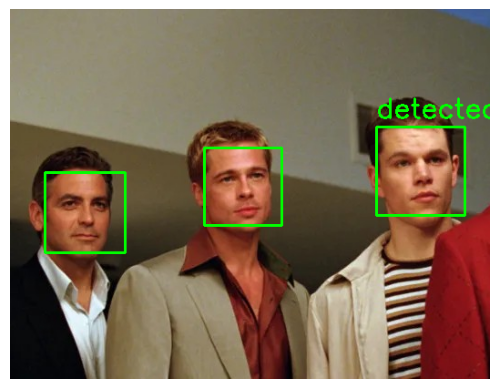

In [13]:


# Input image path (group photo)
img_path = r"D:\GitHub\Movie Shazam\Face Rec\MVP\test_input_photos\MCDOCEL_EC004.jpg"

# Face database path
db_path = "D:\GitHub\Movie Shazam\Face Rec\MVP\oceans_11_db"

# Create a directory to store cropped faces
output_dir = "D:\GitHub\Movie Shazam\Face Rec\MVP\oceans_11_db\detected_faces"
os.makedirs(output_dir, exist_ok=True)

# Step 1: Detect Multiple Faces
faces = DeepFace.extract_faces(img_path, enforce_detection=False, detector_backend="opencv")

detected_faces = []
face_bounding_boxes = []  # Store bounding boxes separately

for i, face in enumerate(faces):
    # Convert face image to numpy array
    face_array = np.array(face["face"])

    # Convert from float64 (0-1) to uint8 (0-255)
    face_array = (face_array * 255).astype(np.uint8)

    # Save cropped face
    face_path = f"{output_dir}/face_{i}.jpg"
    cv2.imwrite(face_path, cv2.cvtColor(face_array, cv2.COLOR_RGB2BGR))

    detected_faces.append(face_path)
    face_bounding_boxes.append(face["facial_area"])  # Store bounding box for later

print(f"✅ Saved {len(detected_faces)} faces successfully!")

# Step 2: Match Each Face Against the Database
results = []
for face_path in detected_faces:
    df = DeepFace.find(
        img_path=face_path,
        db_path=db_path,
        enforce_detection=False,
        model_name="Facenet512",  # ✅ Faster model
        detector_backend="opencv",  # ✅ Faster face detector
        distance_metric="euclidean_l2",  # ✅ Less computationally expensive
        silent=False  # ✅ Doesnt Suppress logs
    )
    if len(df) > 0:
        results.append(df[0])  # Append first match

# Merge all results into a single DataFrame
df_results = pd.concat(results) if results else pd.DataFrame()
print("\n🔍 Matching Results:")
print(df_results[["identity", "distance", "threshold"]])

# Step 3: Filter and Keep Only the Best Matches per Person
best_matches = df_results[df_results["distance"] < df_results["threshold"]]

# Extract unique best matches per person
unique_best_matches = {}
for identity_path, distance in zip(best_matches["identity"], best_matches["distance"]):
    person_name = os.path.basename(os.path.dirname(identity_path))  # Extract folder name

    # Store only the first occurrence of each person
    if person_name not in unique_best_matches:
        unique_best_matches[person_name] = (identity_path, distance)

# Sort matches by distance (best match first)
unique_best_matches_sorted = sorted(unique_best_matches.items(), key=lambda x: x[1][1])

# Extract only the names for display
best_match_names = [name for name, _ in unique_best_matches_sorted]
print("\n✅ Unique Best Match Names:")
print(best_match_names)

# Step 4: Draw Bounding Boxes and Overlay Names on the Original Image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Dictionary to store face bounding boxes with matched names
identity_map = {v[0]: k for k, v in unique_best_matches.items()}  # {image_path: person_name}

# Draw bounding boxes and annotate identities
for (face_box, face_path) in zip(face_bounding_boxes, detected_faces):
    x, y, w, h = face_box["x"], face_box["y"], face_box["w"], face_box["h"]

    # Draw bounding box
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Find the matched identity (folder name)
    matched_identity = None
    for identity_path, person_name in identity_map.items():
        if os.path.basename(identity_path) in face_path:
            matched_identity = person_name

    # Display the name above the face
    if matched_identity:
        cv2.putText(image, matched_identity, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Display the image with bounding boxes and labels
plt.imshow(image)
plt.axis("off")
plt.show()


In [14]:
#get clooney movies

def get_clooney_movies():
    url = "https://en.wikipedia.org/wiki/George_Clooney_filmography"
    response = requests.get(url)
    
    if response.status_code != 200:
        print("Failed to retrieve the page")
        return []
    
    soup = BeautifulSoup(response.text, "html.parser")
    movies = []
    
    # Locate the filmography table
    tables = soup.find_all("table", class_="wikitable")
    if not tables:
        print("No filmography table found")
        return []
    
    film_table = tables[0]  # The first table is usually for films
    
    # Extract movie titles from the table
    for row in film_table.find_all("tr")[1:]:  # Skip header row
        cols = row.find_all("td")
        if len(cols) > 1:  # Ensure there's a second column for titles
            movie_title = cols[1].get_text(strip=True)
            movies.append(movie_title)
    
    return movies

def save_to_csv(movies, filename="clooney_movies.csv"):
    with open(filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Movie Title"])
        for movie in movies:
            writer.writerow([movie])

if __name__ == "__main__":
    movie_list = get_clooney_movies()
    save_to_csv(movie_list)
    print(f"Movies starring George Clooney saved to clooney_movies.csv")


Movies starring George Clooney saved to clooney_movies.csv


In [15]:
#brad pitt webscaper
import requests
from bs4 import BeautifulSoup
import csv

def get_brad_pitt_movies():
    url = "https://en.wikipedia.org/wiki/Brad_Pitt_filmography"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print("Failed to retrieve page")
        return []
    
    soup = BeautifulSoup(response.text, "html.parser")
    movies = []
    
    filmography_table = soup.find("table", class_="wikitable")
    if filmography_table:
        for row in filmography_table.find_all("tr")[1:]:  # Skip header row
            columns = row.find_all("td")
            if columns:
                movie_title = columns[0].get_text(strip=True)
                movies.append(movie_title)
    
    return movies

def export_to_csv(movies, filename="brad_pitt_movies.csv"):
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Movie Title"])
        for movie in movies:
            writer.writerow([movie])

if __name__ == "__main__":
    movie_list = get_brad_pitt_movies()
    export_to_csv(movie_list)
    for movie in movie_list:
        print(movie)


Hunk
No Man's Land
Less than Zero
No Way Out
The Dark Side of the Sun
Happy Together
Cutting Class
Across the Tracks
Thelma & Louise
Johnny Suede
Cool World
Contact
A River Runs Through It
Kalifornia
True Romance
The Favor
Interview with the Vampire
Legends of the Fall
Seven
12 Monkeys
Sleepers
The Devil's Own
Seven Years in Tibet
Meet Joe Black
Fight Club
Snatch
The Mexican
Spy Game
Ocean's Eleven
Sinbad: Legend of the Seven Seas
Troy
Ocean's Twelve
Mr. & Mrs. Smith
God Grew Tired of Us
The Departed
Running with Scissors
Babel
The Tehuacan Project
Year of the Dog
A Mighty Heart
Ocean's Thirteen
The Assassination of Jesse Jamesby the Coward Robert Ford
Burn After Reading
The Curious Case of Benjamin Button
Inglourious Basterds
The Time Traveler's Wife
The Private Lives of Pippa Lee
Megamind
Kick-Ass
Eat Pray Love
The Tree of Life
Moneyball
Happy Feet Two
Killing Them Softly
World War Z
Big Men
12 Years a Slave
The Counselor
Fury
Selma
True Story
The Audition
By the Sea
Hitting the Apex

In [4]:
import requests
from bs4 import BeautifulSoup
import csv

def scrape_matt_damon_filmography():
    url = "https://editorial.rottentomatoes.com/guide/all-matt-damon-movies-ranked-by-tomatometer/"
    response = requests.get(url)
    
    if response.status_code != 200:
        print("Failed to retrieve the page")
        return
    
    soup = BeautifulSoup(response.text, 'html.parser')
    movies = []
    
    for movie in soup.find_all('div', class_='article_movie_title'):  # Adjust selector to match actual page structure
        movie_name = movie.get_text(strip=True)
        movies.append(movie_name)
    
    if not movies:
        print("No movies found. Check the HTML structure.")
        return
    
    with open("matt_damon_filmography.csv", "w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Movie Name"])
        writer.writerows([[movie] for movie in movies])
    
    print("CSV file created successfully with", len(movies), "movies.")

if __name__ == "__main__":
    scrape_matt_damon_filmography()


CSV file created successfully with 53 movies.


In [3]:
#clean matt damon csv
# Function to remove text after "(" in a string
def remove_text_after_parenthesis(text):
    if '(' in text:
        return text.split('(')[0].strip()  # Keep text before '('
    return text

# Input and output CSV file names
input_file = 'D:\GitHub\Movie Shazam\Face Rec\MVP\matt_damon_filmography.csv'  # Replace with your input file name
output_file = 'matt_damon_cleaned.csv'  # Output file name

# Read the CSV, modify the data, and write to a new file
with open(input_file, 'r', newline='', encoding='utf-8') as infile, \
     open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    
    reader = csv.reader(infile)
    writer = csv.writer(outfile)

    # Iterate through rows
    for row in reader:
        # Remove text after "(" in each element of the row
        modified_row = [remove_text_after_parenthesis(cell) for cell in row]
        writer.writerow(modified_row)

print(f"Processed data has been written to {output_file}")


Processed data has been written to matt_damon_cleaned.csv


In [16]:
#output shared movies
def find_shared_rows(file1, file2, file3):
    # Read CSV files
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    df3 = pd.read_csv(file3)

    # Find shared rows
    shared_rows = df1.merge(df2).merge(df3)

    return shared_rows

# Example usage
file1 = r"D:\GitHub\Movie Shazam\Face Rec\MVP\brad_pitt_movies.csv"
file2 = r"D:\GitHub\Movie Shazam\Face Rec\MVP\clooney_movies.csv"
file3 = r"D:\GitHub\Movie Shazam\Face Rec\MVP\matt_damon_cleaned.csv"

shared = find_shared_rows(file1, file2, file3)

# Print or save the result
print("Shared Rows:")
print(shared)

# Optionally save to a new CSV
#shared.to_csv("shared_rows.csv", index=False)


Shared Rows:
      Movie Title
0  Ocean's Eleven
1  Ocean's Twelve
